In [1]:
# https://zhuanlan.zhihu.com/p/336544299

import numpy as np
from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen
import PIL.ImageStat as stat
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from skimage import color, viewer, exposure, img_as_float, data
from skimage.transform import SimilarityTransform, warp, swirl
from skimage.util import invert, random_noise, montage
import matplotlib.image as mpimg
import matplotlib.pylab as plt
from scipy.ndimage import affine_transform, zoom
from scipy import misc


C:\Users\Alephant\anaconda3\envs\Dicom_analysis\lib\importlib\__init__.py:126: UserWarning: viewer requires Qt
  return _bootstrap._gcd_import(name[level:], package, level)


In [11]:
im = Image.open("./images/parrot.jpg") # read the image, provide the correct path
print(im.width, im.height, im.mode, im.format, type(im))
# 453 340 RGB PNG <class 'PIL.PngImagePlugin.PngImageFile'>
im.show() # display the image

640 480 RGB JPEG <class 'PIL.JpegImagePlugin.JpegImageFile'>


In [12]:
im_g = im.convert('L') # convert the RGB color image to a grayscale image
im_g.save('./images/parrot_gray.png') # save the image to disk
Image.open("./images/parrot_gray.png").show() # read the grayscale image from disk and show


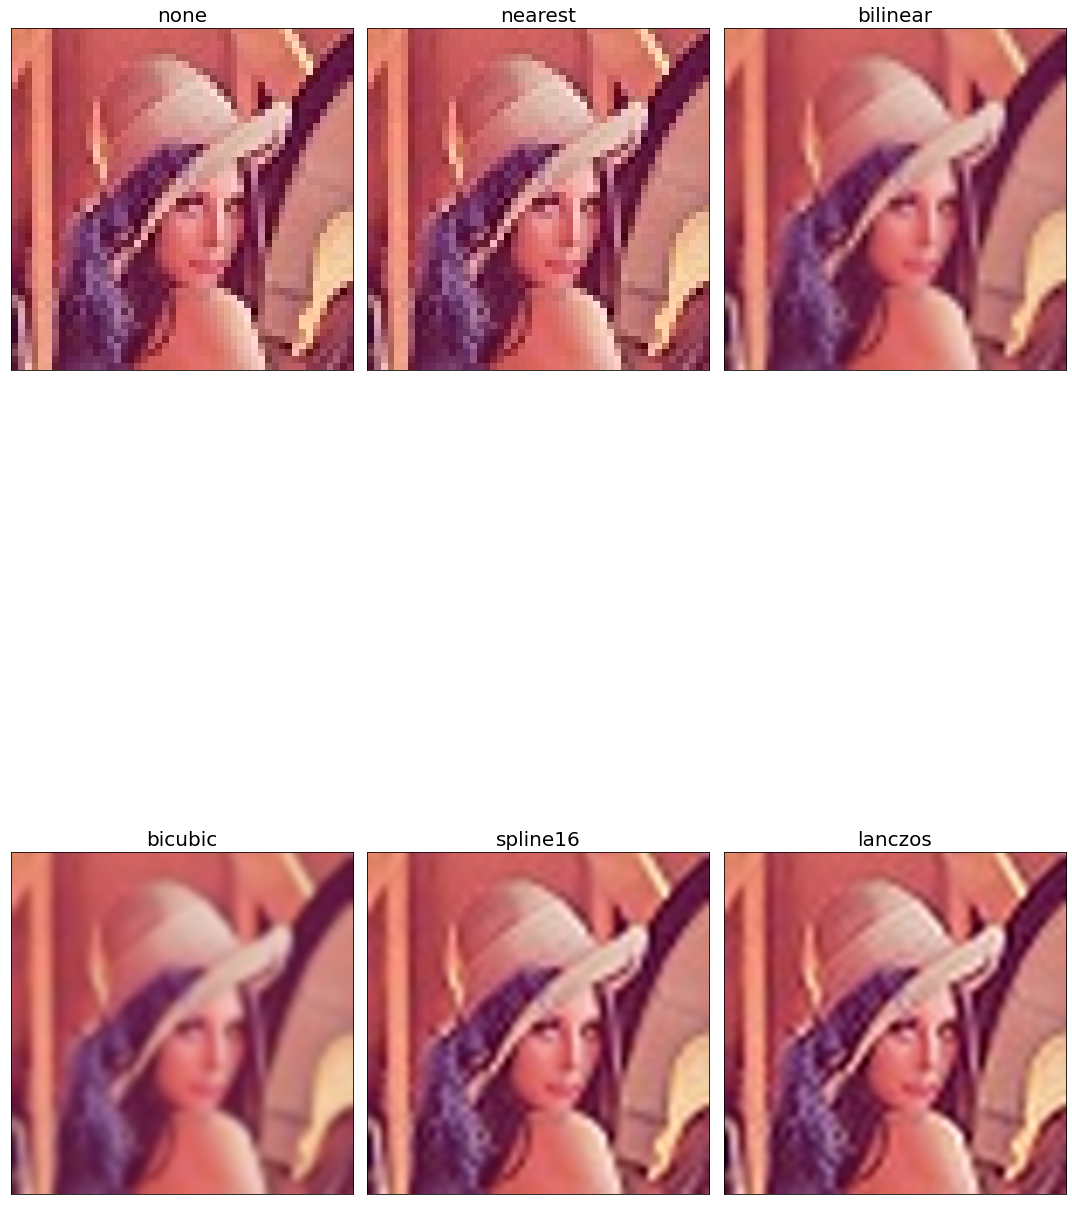

In [2]:
im = mpimg.imread("./images/lena_small.png") # read the image from disk as a numpy ndarray
methods = ['none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'lanczos']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 30),subplot_kw={'xticks': [],
'yticks': []})
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for ax, interp_method in zip(axes.flat, methods):
    ax.imshow(im, interpolation=interp_method)
    ax.set_title(str(interp_method), size=20)
plt.tight_layout()
plt.show()

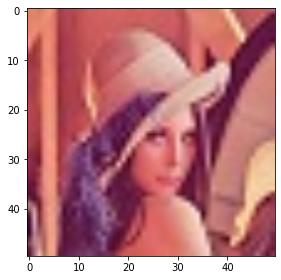

In [21]:
plt.imshow(im, interpolation='bilinear')
plt.tight_layout()
plt.show()

In [49]:
def img_resize(img, mag=1, method='nearest'):
    mag = float(mag) # 将倍率强制转换为浮点数
    height, width = img.shape[0], img.shape[1] # 获取原图的高和宽
    new_h, new_w = int(height * mag), int(width * mag) # 计算新图的高和宽
    new_img = np.zeros((new_h,new_w,3)) # 初始化新图的张量

    # 最临近值插值
    if method == 'nearest':
        # 遍历每个新图的像素点，在这里高坐标代表y轴坐标，宽坐标代表x轴坐标
        for new_h_y in range(new_h):
            for new_h_x in range(new_w):
                # 原来的宽、高坐标与新坐标的关系是有一个倍率的整数
                w_x = int(new_h_x / mag)
                h_y = int(new_h_y / mag)
                # 在新图该位置赋值
                new_img[new_h_y, new_h_x] = img[h_y, w_x]
        return new_img


    # 双线性插值
    elif method == 'bilinear':
        # 遍历每个新图的像素点
        for new_h_y in range(new_h):
            for new_h_x in range(new_w):
                # 将每个像素看做正方形，进行中心对齐，投影目标图的横轴和纵轴到原图上
                w_x = (new_h_x + 0.5) / mag - 0.5
                h_y = (new_h_y +0.5) / mag - 0.5

                # 找出每个投影点在原图横轴方向的近邻点坐标
                # 原图范围是0~width-2, 0~height-2是因为要考虑+1后的边界
                f_x = np.clip(w_x, 0, width-2).astype(np.int)
                f_y = np.clip(h_y, 0, height-2).astype(np.int)

                # 给出原轴的4个最近邻点Q坐标
                x1, x2 = f_x, f_x+1
                y1, y2 = f_y, f_y+1

                # 给出这四个Q点对应的权重，注意图像数据中y轴在第一位，x轴在第二位
                f_Q11 = img[y1, x1]
                f_Q12 = img[y2, x1]
                f_Q21 = img[y1, x2]
                f_Q22 = img[y2, x2]

                # 计算两个R点对应的权重
                f_R1 = (x2 - w_x) / (x2 - x1)*f_Q11 + (w_x - x1) / (x2 - x1)*f_Q21
                f_R2 = (x2 - w_x) / (x2 - x1)*f_Q12 + (w_x - x1) / (x2 - x1)*f_Q22

                # 计算投影点P的双线性插值，将其赋值于新图该点像素
                f_P = (y2 - h_y) / (y2 - y1)*f_R1 + (h_y - y1) / (y2 - y1)*f_R2
                new_img[new_h_y, new_h_x] = f_P
        return new_img







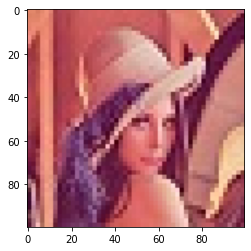

In [53]:
neIm1 = img_resize(im, mag=2)
plt.imshow(neIm1)

C:\Users\Alephant\AppData\Local\Temp\ipykernel_14260\2764738729.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  f_x = np.clip(x, 0, w-2).astype(np.int)
C:\Users\Alephant\AppData\Local\Temp\ipykernel_14260\2764738729.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

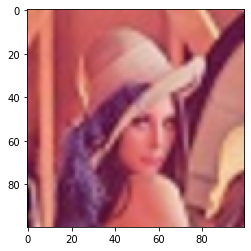

In [54]:
neIm2 = img_resize(im, mag=2, method='bilinear')
plt.imshow(neIm2)
